In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn pyod tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.3-py3-none-any.whl size=200466 sha256=d5b1ec911fb36bd41ddc1fcc739788c5bac4d19a6cabdce2c7d976579c185086
  Stored in directory: /root/.cache/pip/wheels/2d/60/5b/f74eccd2c9c892a2c298202ca510f10995f9940647fcc2d97f
Successfully built pyod


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from pyod.models.gmm import GMM
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from pyod.models.iforest import IForest
# from pyod.models.gmm import GMM
# from sklearn.svm import OneClassSVM
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense
# import numpy as np
# from sklearn.model_selection import train_test_split


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Encoding Functions ------------------

def encode_pm25(pm25):
    """
    Encodes PM2.5 value into a numeric score:
      1: Good (0–30 µg/m³)
      2: Satisfactory (31–60 µg/m³)
      3: Moderate (61–90 µg/m³)
      4: Poor (91–120 µg/m³)
      5: Very Poor (121–250 µg/m³)
      6: Severe (251 µg/m³ and above)
    """
    if pm25 <= 30:
        return 1
    elif pm25 <= 60:
        return 2
    elif pm25 <= 90:
        return 3
    elif pm25 <= 120:
        return 4
    elif pm25 <= 250:
        return 5
    else:
        return 6

def encode_pm10(pm10):
    """
    Encodes PM10 value into a numeric score:
      1: Good (0–50 µg/m³)
      2: Satisfactory (51–100 µg/m³)
      3: Moderately Polluted (101–250 µg/m³)
      4: Poor (251–350 µg/m³)
      5: Very Poor (351–430 µg/m³)
      6: Severe (431 µg/m³ and above)
    """
    if pm10 <= 50:
        return 1
    elif pm10 <= 100:
        return 2
    elif pm10 <= 250:
        return 3
    elif pm10 <= 350:
        return 4
    elif pm10 <= 430:
        return 5
    else:
        return 6

def combined_air_quality_label(pm25, pm10):
    """
    Combines PM2.5 and PM10 numeric scores by taking the floor of the average.
    For example, if one pollutant is 'Severe' (6) and the other 'Moderate' (3),
    the average (4.5) is floored to 4, which we interpret as 'Poor'.
    """
    score_pm25 = encode_pm25(pm25)
    score_pm10 = encode_pm10(pm10)
    # Floor the average using integer division (works for positive numbers)
    combined_score = (score_pm25 + score_pm10) // 2
    return combined_score

# Optional mapping back to text label if needed
combined_labels = {
    1: "Good",
    2: "Satisfactory",
    3: "Moderate",
    4: "Poor",
    5: "Very Poor",
    6: "Severe"
}

def process_air_quality_data(df):
    """
    Processes a DataFrame containing 'pm25' and 'pm10' columns:
      - Encodes each pollutant into its numeric score.
      - Creates a combined score.
      - Retains only numeric columns.
    """
    df['pm25_numeric'] = df['pm25'].apply(encode_pm25)
    df['pm10_numeric'] = df['pm10'].apply(encode_pm10)
    df['combined_numeric'] = df.apply(
        lambda row: combined_air_quality_label(row['pm25'], row['pm10']),
        axis=1
    )
    df['combined_label'] = df['combined_numeric'].map(combined_labels)

    # Keep only numeric columns (if desired)
    df_numeric = df.select_dtypes(include=[np.number])
    return df_numeric

# ------------------ Misclassification Identification ------------------

def check_misclassification(row, pollutant):
    """
    Identifies if the anomaly detection for a row is a misclassification.

    Logic:
      - Computes the combined numeric air quality label using both 'pm2.5cnc' and 'pm10cnc' columns.
      - If an anomaly is flagged (column value 1) but the combined label is in a milder category (1, 2, or 3),
        it is a misclassification.
      - If no anomaly is flagged (0) but the combined label is in a worse category (4, 5, or 6),
        it is a misclassification.

    Returns:
      - True if misclassification, False otherwise.
    """
    # Compute combined numeric label from the pollutant values (assumes both columns are available)
    combined = combined_air_quality_label(row["pm2.5cnc"], row["pm10cnc"])

    # Determine the anomaly flag column (e.g., "Anomaly_pm25cnc_features" for "pm2.5cnc")
    anomaly_col = f"Anomaly_{pollutant.replace('.', '')}"
    anomaly_flag = row[anomaly_col]

    if anomaly_flag == 1 and combined in [1, 2, 3]:
        return True
    # elif anomaly_flag == 0 and combined in [4, 5, 6]:
    #     return True
    else:
        return False

In [4]:
import numpy as np  # Add this import statement at the beginning of the code




def clean_and_prepare(df):
    """
    Cleans and prepares the dataframe:
    - Ensures datetime index
    - Handles missing values without affecting outlier detection
    - Creates time-based features
    - Drops non-numeric data
    """

    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df["dt_time"] = pd.to_datetime(df["dt_time"])
        df = df.set_index("dt_time")

    # Remove non-relevant columns
    if "deviceid" in df.columns:
        df.drop(columns=["deviceid"], inplace=True)

    # Interpolate missing values using time-based method
    df.interpolate(method="time", inplace=True)

    # Create time-based features
    df["hour"] = df.index.hour
    df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24)
    # df["day_of_week"] = df.index.dayofweek
    # df["sin_day"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    # df["cos_day"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

    # Lag Features (Avoid NaNs)
    df["pm2.5_lag1"] = df["pm2.5cnc"].shift(1).bfill()
    df["pm2.5_lag2"] = df["pm2.5cnc"].shift(2).bfill()
    df["pm10_lag1"] = df["pm10cnc"].shift(1).bfill()
    df["pm10_lag2"] = df["pm10cnc"].shift(2).bfill()

    # Month & Seasonal Encoding
    df["month"] = df.index.month

    def get_season(month):
        if month in [1, 2]:
            return "Winter"
            return "Summer (Pre-Monsoon)"
        elif month in [6, 7, 8, 9]:
            return "Monsoon"
        else:
            return "Post-Monsoon (Autumn)"

    df["season"] = df["month"].apply(get_season)
    df["season_code"] = pd.Categorical(df["season"]).codes

    # Weekend Indicator
    # df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

    # Rate of Change Features
    # df["pm2.5_diff"] = df["pm2.5cnc"].diff().fillna(0)  # Avoid NaNs
    # df["pm10_diff"] = df["pm10cnc"].diff().fillna(0)  # Avoid NaNs

    # Drop Non-Numeric Columns
    df.drop(columns=["season"], inplace=True)
    # df.drop(columns=["hour"], inplace=True)
    # df.drop(columns=["minute"], inplace=True)


    # Final NaN Handling (Ensures No NaNs Remain)
    df.fillna(method="ffill", inplace=True)  # Forward-fill
    df.fillna(method="bfill", inplace=True)  # Back-fill

    return df


In [9]:
def run_isoforest(train_data):
    """
    Trains an Isolation Forest on the given training data.
    Converts detected anomalies (-1) to normal (1) only if they fall within safe AQI ranges:
      - For 'pm2.5cnc': safe range is 0 to 90.
      - For 'pm10cnc': safe range is 0 to 350.
    Returns: (model, scores, labels)
    """
    # Train the model
    model = IsolationForest(n_estimators=100, contamination=0.2, random_state=42)
    model.fit(train_data)

    # Get outputs from Isolation Forest
    scores = model.decision_function(train_data)  # Higher => more normal
    labels = model.predict(train_data)              # 1 => normal, -1 => anomaly

    # Define safe range mask based on available pollutant columns
    # safe_range_mask = None
    # if 'pm2.5cnc' in train_data.columns and 'pm10cnc' in train_data.columns:
    #     mask_pm25 = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 90)
    #     mask_pm10 = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)
    #     safe_range_mask = mask_pm25 & mask_pm10
    # elif 'pm2.5cnc' in train_data.columns:
    #     safe_range_mask = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 90)
    # elif 'pm10cnc' in train_data.columns:
    #     safe_range_mask = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)

    # # For rows flagged as anomaly (-1) but within the safe range, force them to normal (1)
    # if safe_range_mask is not None:
    #     labels = np.where((labels == -1) & safe_range_mask, 1, labels)

    return model, scores, labels


def run_svm(train_data):
    """
    Trains a One-Class SVM on the given training data.
    Converts detected anomalies (-1) to normal (1) only if they fall within safe AQI ranges:
      - For 'pm2.5cnc': safe range is 0 to 90.
      - For 'pm10cnc': safe range is 0 to 350.
    Returns: (model, scores, labels)
    """
    # Train the model
    model = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
    model.fit(train_data)

    # Get outputs from One-Class SVM
    scores = model.decision_function(train_data)  # Higher => more normal
    labels = model.predict(train_data)              # 1 => normal, -1 => anomaly

    # Define safe range mask based on available pollutant columns
    safe_range_mask = None
    if 'pm2.5cnc' in train_data.columns and 'pm10cnc' in train_data.columns:
        mask_pm25 = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 250)
        mask_pm10 = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)
        safe_range_mask = mask_pm25 & mask_pm10
    elif 'pm2.5cnc' in train_data.columns:
        safe_range_mask = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 250)
    elif 'pm10cnc' in train_data.columns:
        safe_range_mask = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)

    # For rows flagged as anomaly (-1) but within the safe range, force them to normal (1)
    if safe_range_mask is not None:
        labels = np.where((labels == -1) & safe_range_mask, 1, labels)

    return model, scores, labels

def split_data_random(df):
    """
    Splits the dataset into train (70%), test (20%), and validation (10%).

    Parameters:
    df (DataFrame): The dataset to split.

    Returns:
    train (DataFrame): 70% of data for training.
    test (DataFrame): 20% of data for testing.
    validation (DataFrame): 10% of data for final validation.
    """
    train, temp = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% temp
    test, validation = train_test_split(temp, test_size=1/3, random_state=42)  # 20% test, 10% validation
    return train, test, validation

def split_data(df):
    """
    Splits the dataset into train (70%), test (20%), and validation (10%)
    in a historical order (earliest to latest).

    Parameters:
    df (DataFrame): The dataset to split. Assumes it is sorted by timestamp.

    Returns:
    train (DataFrame): First 70% of data for training.
    test (DataFrame): Next 20% of data for testing.
    validation (DataFrame): Final 10% of data for validation.
    """
    # Ensure data is sorted by timestamp (assuming a 'timestamp' column exists)
    df = df.sort_values(by='dt_time')

    # Compute split indices
    n = len(df)
    train_end = int(n * 0.7)
    test_end = int(n * 0.9)  # 70% train + 20% test = 90%, remaining 10% is validation

    # Split sequentially
    train = df.iloc[:train_end]
    test = df.iloc[train_end:test_end]
    validation = df.iloc[test_end:]

    return train, test, validation



In [11]:
df = pd.read_csv("/content/site_104_data.csv")

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature Design Function
def calculate_feature_design(df, pollutant_1, pollutant_2, location_score, lambda_decay=0.1, epsilon=1e-6):
    """
    Applies feature design calculations based on the provided formula.
    """
    df = df.reset_index()
    # Ensure datetime index
    df["dt_time"] = pd.to_datetime(df["dt_time"], errors='coerce')
    df.set_index("dt_time", inplace=True)

    # Fill NaNs to prevent issues
    df[pollutant_1] = df[pollutant_1].fillna(df[pollutant_1].median())
    df[pollutant_2] = df[pollutant_2].fillna(df[pollutant_2].median())

    # Z-score normalization
    df['Z_pm25'] = (df[pollutant_1] - df[pollutant_1].rolling(window=24, min_periods=1).mean()) / \
                   (df[pollutant_1].rolling(window=12, min_periods=1).std() + epsilon)
    df['Z_pm10'] = (df[pollutant_2] - df[pollutant_2].rolling(window=24, min_periods=1).mean()) / \
                   (df[pollutant_2].rolling(window=12, min_periods=1).std() + epsilon)

    # Dynamic weight contributions
    df['W_pm25'] = 1
    df['W_pm10'] = 1

    # Time-based weight (exponential decay function)
    df['T_weight'] = np.exp(-lambda_decay * (df.index - df.index.min()).total_seconds() / 86400)

    # Recent change rate (captures sudden variations)
    df['R_change'] = ((df[pollutant_1] - df[pollutant_1].shift(1)) / (df[pollutant_1].shift(1) + epsilon)) + \
                     ((df[pollutant_2] - df[pollutant_2].shift(1)) / (df[pollutant_2].shift(1) + epsilon))

    # Final feature calculation (F_t)
    df['F_t'] = ((df['Z_pm25'] * df['W_pm25']) + (df['Z_pm10'] * df['W_pm10']) +
                 (location_score * df['T_weight']) + df['R_change'])

    return df

df = calculate_feature_design(df, "pm2.5cnc", "pm10cnc", 0.5)

print(df)
# Process and Detect Anomalies
def process_and_plot_anomalies(file_path, model_type, pollutant):
    """
    Generic anomaly detection pipeline for PM2.5 or PM10.
    """
    # df = pd.read_csv(file_path, parse_dates=["dt_time"])

    if pollutant not in ["pm2.5cnc", "pm10cnc"]:
        raise ValueError("Invalid pollutant. Choose 'pm2.5cnc' or 'pm10cnc'.")

    anomaly_col = f"Anomaly_{pollutant.replace('.', '')}"

    # Apply feature engineering before splitting data


    train, test, validation = split_data_random(df)

    model_functions = {
        "svm": run_svm,
        "iforest": run_isoforest,
    }

    if model_type not in model_functions:
        raise ValueError("Invalid model_type. Choose from 'svm', 'iforest'.")

    # Ensure all required columns exist
    feature_columns = ["pm2.5cnc", "pm10cnc", "F_t", "Z_pm25", "Z_pm10", "T_weight", "R_change"]
    for col in feature_columns:
        if col not in df.columns:
            raise ValueError(f"Column {col} is missing from dataframe!")

    train_data = train[feature_columns]
    test_data = test[feature_columns]
    val_data = validation[feature_columns]

    model, train_scores, train_labels = model_functions[model_type](train_data)
    _, test_scores, test_labels = model_functions[model_type](test_data)
    _, val_scores, val_labels = model_functions[model_type](val_data)

    train["Anomaly"] = (train_labels == -1).astype(int)
    test["Anomaly"] = (test_labels == -1).astype(int)
    validation["Anomaly"] = (val_labels == -1).astype(int)

    df[anomaly_col] = 0
    df.loc[train.index, anomaly_col] = train["Anomaly"]
    df.loc[test.index, anomaly_col] = test["Anomaly"]
    df.loc[validation.index, anomaly_col] = validation["Anomaly"]

    if model_type == 'iforest':
        df["Anomaly_IsoForest"] = df[anomaly_col]

    misclass_col = f"Misclassification_{pollutant.replace('.', '')}"
    df[misclass_col] = df.apply(lambda row: check_misclassification(row, pollutant), axis=1)

    plt.figure(figsize=(12, 5))
    plt.scatter(train.index, train[pollutant], c=train["Anomaly"], cmap="coolwarm", label="Train", s=15)
    plt.title(f"{pollutant.upper()} Concentration Anomalies ({model_type.upper()})")
    plt.xlabel("Time")
    plt.ylabel(f"{pollutant} Concentration")
    plt.legend()
    plt.show()

    print(f"Train anomalies ({pollutant}): {train['Anomaly'].sum()}")
    print(f"Test anomalies ({pollutant}): {test['Anomaly'].sum()}")
    print(f"Validation anomalies ({pollutant}): {validation['Anomaly'].sum()}")

    total_misclassified = df[misclass_col].sum()
    print(f"Total misclassifications for {pollutant}: {total_misclassified}")

    return df


                     index     id  pm2.5cnc  pm10cnc  deviceid    Z_pm25  \
dt_time                                                                    
2021-10-26 15:00:00      0      1    352.34   186.31  site_104       NaN   
2021-10-26 15:30:00      1      2    327.90   186.31  site_104 -0.707107   
2021-10-26 16:00:00      2      3     77.60   186.31  site_104 -1.150966   
2021-10-26 16:30:00      3      4     14.85   186.31  site_104 -1.037403   
2021-10-26 17:00:00      4      5     79.68   186.31  site_104 -0.577282   
...                    ...    ...       ...      ...       ...       ...   
2025-03-13 22:00:00  59246  59247     89.12   163.44  site_104  2.144067   
2025-03-13 22:30:00  59247  59248     89.39   166.28  site_104  1.910788   
2025-03-13 23:00:00  59248  59249    108.27   180.14  site_104  2.629132   
2025-03-13 23:30:00  59249  59250    103.26   223.81  site_104  1.912869   
2025-03-14 00:00:00  59250  59251    100.13   233.72  site_104  1.480025   

           

<ipython-input-12-9f9a771d8401>:12: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["dt_time"] = pd.to_datetime(df["dt_time"], errors='coerce')


In [17]:
print(df)

                     index     id  pm2.5cnc  pm10cnc  deviceid    Z_pm25  \
dt_time                                                                    
2021-10-26 15:00:00      0      1    352.34   186.31  site_104       NaN   
2021-10-26 15:30:00      1      2    327.90   186.31  site_104 -0.707107   
2021-10-26 16:00:00      2      3     77.60   186.31  site_104 -1.150966   
2021-10-26 16:30:00      3      4     14.85   186.31  site_104 -1.037403   
2021-10-26 17:00:00      4      5     79.68   186.31  site_104 -0.577282   
...                    ...    ...       ...      ...       ...       ...   
2025-03-13 22:00:00  59246  59247     89.12   163.44  site_104  2.144067   
2025-03-13 22:30:00  59247  59248     89.39   166.28  site_104  1.910788   
2025-03-13 23:00:00  59248  59249    108.27   180.14  site_104  2.629132   
2025-03-13 23:30:00  59249  59250    103.26   223.81  site_104  1.912869   
2025-03-14 00:00:00  59250  59251    100.13   233.72  site_104  1.480025   

           

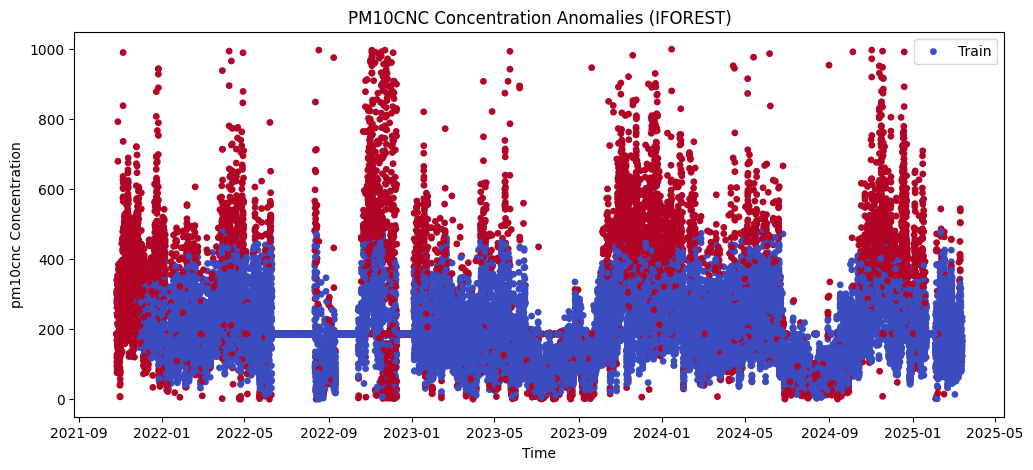

Train anomalies (pm10cnc): 8295
Test anomalies (pm10cnc): 2370
Validation anomalies (pm10cnc): 1185
Total misclassifications for pm10cnc: 3734


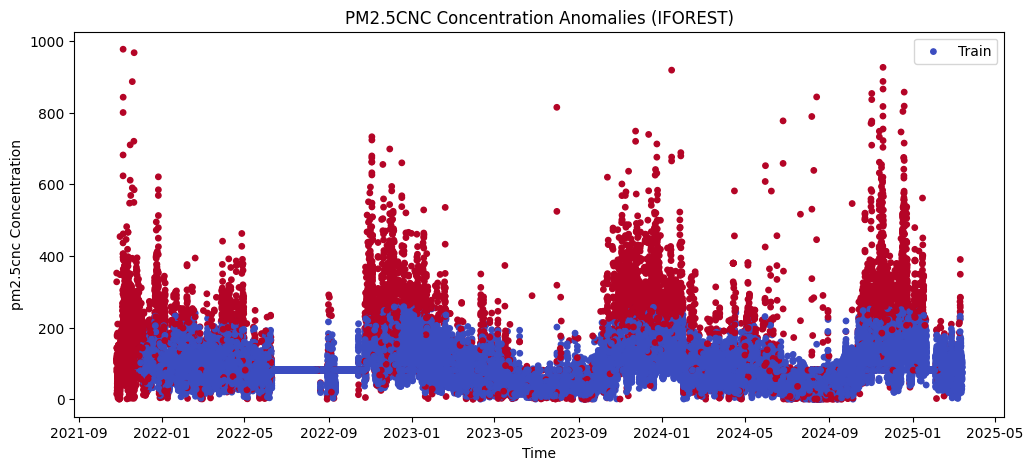

Train anomalies (pm2.5cnc): 8295
Test anomalies (pm2.5cnc): 2370
Validation anomalies (pm2.5cnc): 1185
Total misclassifications for pm2.5cnc: 3734


In [18]:
file_path = "/content/site_104_data.csv"
df10iforest = process_and_plot_anomalies(file_path, model_type="iforest", pollutant="pm10cnc")
df25iforest = process_and_plot_anomalies(file_path, model_type="iforest", pollutant="pm2.5cnc")

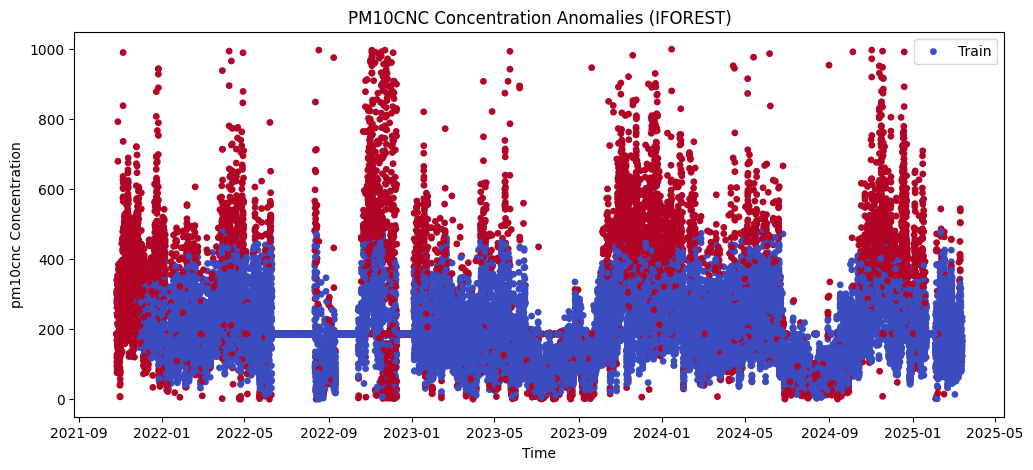

Train anomalies (pm10cnc): 8295
Test anomalies (pm10cnc): 2370
Validation anomalies (pm10cnc): 1185
Total misclassifications for pm10cnc: 3734


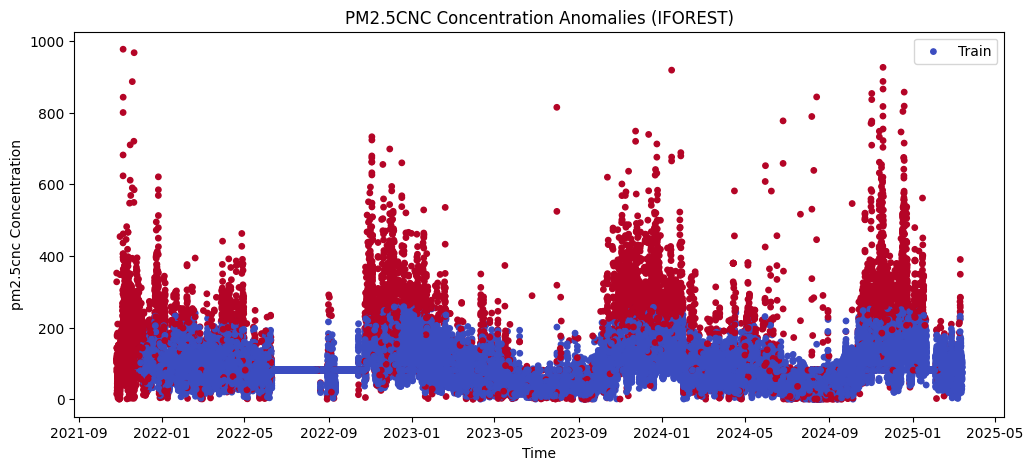

Train anomalies (pm2.5cnc): 8295
Test anomalies (pm2.5cnc): 2370
Validation anomalies (pm2.5cnc): 1185
Total misclassifications for pm2.5cnc: 3734


In [19]:
file_path = "/content/site_104_data.csv"
df10iforest = process_and_plot_anomalies(file_path, model_type="iforest", pollutant="pm10cnc")
df25iforest = process_and_plot_anomalies(file_path, model_type="iforest", pollutant="pm2.5cnc")


In [20]:
print(df.columns)

Index(['index', 'id', 'pm2.5cnc', 'pm10cnc', 'deviceid', 'Z_pm25', 'Z_pm10',
       'W_pm25', 'W_pm10', 'T_weight', 'R_change', 'F_t', 'Anomaly_pm10cnc',
       'Anomaly_IsoForest', 'Misclassification_pm10cnc', 'Anomaly_pm25cnc',
       'Misclassification_pm25cnc'],
      dtype='object')


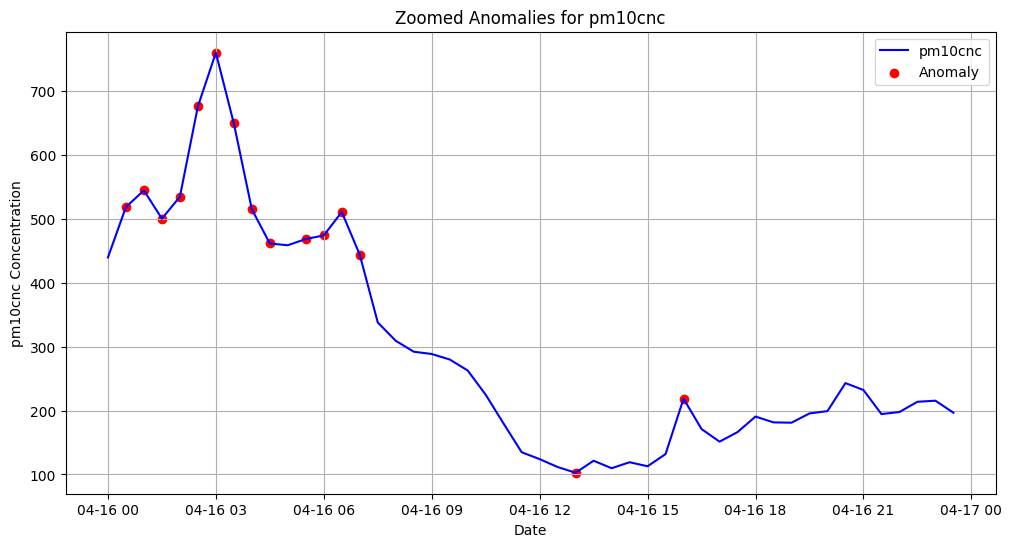

In [23]:
plot_zoomed_anomalies(df10iforest,"2024-04-16","2024-04-16","pm10cnc")

In [22]:
def plot_zoomed_anomalies(df, start_date, end_date, pollutant):
    """
    Plots a zoomed-in view of anomalies for the given pollutant within a date range.

    Parameters:
    - df: DataFrame containing air quality data.
    - start_date: Start date for zooming the data.
    - end_date: End date for zooming the data.
    - pollutant: The pollutant to plot (e.g., "pm2.5cnc" or "pm10cnc").
    """
    # Dynamically create the anomaly column name based on the pollutant
    anomaly_col = f'Anomaly_{pollutant.replace(".", "")}'

    # Ensure the DataFrame index is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)

    # Filter DataFrame for the specified date range
    df_filtered = df.loc[start_date:end_date]

    # Plot the pollutant data
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, df_filtered[pollutant], label=pollutant, color='blue')

    # Highlight anomalies using the found anomaly column
    anomalies = df_filtered[df_filtered[anomaly_col] == 1]
    plt.scatter(anomalies.index, anomalies[pollutant], color='red', label="Anomaly", marker='o')

    # Plot configuration
    plt.xlabel("Date")
    plt.ylabel(f"{pollutant} Concentration")
    plt.title(f"Zoomed Anomalies for {pollutant}")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
plot_zoomed_anomalies(df10iforest,"2024-03-12","2024-03-14","pm10cnc")

In [13]:
import pandas as pd
import numpy as np

def compute_Ft_threshold(csv_path,
                         pm25_col='pm2.5cnc',
                         pm10_col='pm10cnc',
                         location_score=0.5,
                         lambda_decay=0.1,
                         epsilon=1e-6,
                         k=3):
    """
    1. Reads the CSV file.
    2. Computes F_t for each row using rolling statistics and the given formula.
    3. Calculates a threshold using mean + k*std.
    4. Returns a DataFrame with F_t and outlier labels.
    """

    # Read data
    df = pd.read_csv("/content/site_104_data.csv", parse_dates=["dt_time"], infer_datetime_format=True)
    df.set_index("dt_time", inplace=True)

    # Ensure PM columns exist
    for col in [pm25_col, pm10_col]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in CSV. Available columns: {df.columns.tolist()}")

    # Fill NaNs to avoid calculation issues
    df[pm25_col] = df[pm25_col].fillna(df[pm25_col].median())
    df[pm10_col] = df[pm10_col].fillna(df[pm10_col].median())

    # Rolling mean & std (24h mean, 12h std as an example)
    rolling_mean_pm25 = df[pm25_col].rolling(window=24, min_periods=1).mean()
    rolling_std_pm25 = df[pm25_col].rolling(window=12, min_periods=1).std() + epsilon

    rolling_mean_pm10 = df[pm10_col].rolling(window=24, min_periods=1).mean()
    rolling_std_pm10 = df[pm10_col].rolling(window=12, min_periods=1).std() + epsilon

    # Z-scores
    df["Z_pm25"] = (df[pm25_col] - rolling_mean_pm25) / rolling_std_pm25
    df["Z_pm10"] = (df[pm10_col] - rolling_mean_pm10) / rolling_std_pm10

    # Weights (set to 1 by default, but can be tuned)
    df["W_pm25"] = 1.0
    df["W_pm10"] = 1.0

    # Time-based weight (exponential decay)
    # Convert index to "days since start"
    df_sorted = df.sort_index()
    min_time = df_sorted.index.min()
    df_sorted["days_since_start"] = (df_sorted.index - min_time).total_seconds() / 86400
    df_sorted["T_weight"] = np.exp(-lambda_decay * df_sorted["days_since_start"])

    # Recent change rate (shift by 1 row)
    df_sorted["R_change"] = ((df_sorted[pm25_col] - df_sorted[pm25_col].shift(1)) /
                             (df_sorted[pm25_col].shift(1) + epsilon)) \
                            + ((df_sorted[pm10_col] - df_sorted[pm10_col].shift(1)) /
                               (df_sorted[pm10_col].shift(1) + epsilon))

    # Compute F_t
    df_sorted["F_t"] = ((df_sorted["Z_pm25"] * df_sorted["W_pm25"]) +
                        (df_sorted["Z_pm10"] * df_sorted["W_pm10"]) +
                        (location_score * df_sorted["T_weight"]) +
                        df_sorted["R_change"])

    # Drop rows that can't compute R_change for the first row
    df_sorted.dropna(subset=["F_t"], inplace=True)

    # Calculate threshold = mean + k*std
    Ft_mean = df_sorted["F_t"].mean()
    Ft_std = df_sorted["F_t"].std()
    threshold = Ft_mean + k * Ft_std

    # Label outliers
    df_sorted["Outlier"] = (df_sorted["F_t"] > threshold).astype(int)

    print(f"\nCalculated F_t threshold = mean(F_t) + {k} * std(F_t) = {Ft_mean:.3f} + {k} * {Ft_std:.3f} = {threshold:.3f}\n")
    print(f"Number of outliers above threshold: {df_sorted['Outlier'].sum()}")

    return df_sorted, threshold

if __name__ == "__main__":
    # Replace with the path to your CSV file
    csv_file = "site_104_data.csv"

    # Run the function
    results_df, ft_threshold = compute_Ft_threshold(
        csv_path=csv_file,
        pm25_col="pm2.5cnc",  # or your actual PM2.5 column name
        pm10_col="pm10cnc",   # or your actual PM10 column name
        location_score=0.5,
        lambda_decay=0.1,
        epsilon=1e-6,
        k=3
    )

    # Show the last few rows
    print(results_df[["F_t", "Outlier"]].tail(10))


<ipython-input-13-cfa82094282a>:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("/content/site_104_data.csv", parse_dates=["dt_time"], infer_datetime_format=True)
<ipython-input-13-cfa82094282a>:19: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("/content/site_104_data.csv", parse_dates=["dt_time"], infer_datetime_format=True)



Calculated F_t threshold = mean(F_t) + 3 * std(F_t) = -212239.809 + 3 * 7547985.383 = 22431716.339

Number of outliers above threshold: 194
                          F_t  Outlier
dt_time                               
2025-03-13 19:30:00  0.108161        0
2025-03-13 20:00:00 -1.017001        0
2025-03-13 20:30:00  2.015782        0
2025-03-13 21:00:00  3.570818        0
2025-03-13 21:30:00  4.646765        0
2025-03-13 22:00:00  3.075512        0
2025-03-13 22:30:00  3.097591        0
2025-03-13 23:00:00  4.535822        0
2025-03-13 23:30:00  4.620716        0
2025-03-14 00:00:00  3.647245        0


In [16]:
import pandas as pd
import numpy as np

def compute_Ft_threshold(csv_path,
                         pm25_col='pm2.5cnc',
                         pm10_col='pm10cnc',
                         location_score=0.5,
                         lambda_decay=0.1,
                         epsilon=1e-6,
                         k=3):
    df = pd.read_csv(csv_path, parse_dates=["dt_time"], infer_datetime_format=True)
    df.set_index("dt_time", inplace=True)

    # Fill missing PM2.5/PM10
    df[pm25_col] = df[pm25_col].fillna(df[pm25_col].median())
    df[pm10_col] = df[pm10_col].fillna(df[pm10_col].median())

    # Rolling mean & std
    rolling_mean_pm25 = df[pm25_col].rolling(window=24, min_periods=1).mean()
    rolling_std_pm25  = df[pm25_col].rolling(window=12, min_periods=1).std() + epsilon
    rolling_mean_pm10 = df[pm10_col].rolling(window=24, min_periods=1).mean()
    rolling_std_pm10  = df[pm10_col].rolling(window=12, min_periods=1).std() + epsilon

    # Z-scores
    df["Z_pm25"] = (df[pm25_col] - rolling_mean_pm25) / rolling_std_pm25
    df["Z_pm10"] = (df[pm10_col] - rolling_mean_pm10) / rolling_std_pm10

    # Weights
    df["W_pm25"] = 1.0
    df["W_pm10"] = 1.0

    # Time-based weight
    df_sorted = df.sort_index()
    min_time = df_sorted.index.min()
    df_sorted["days_since_start"] = (df_sorted.index - min_time).total_seconds() / 86400
    df_sorted["T_weight"] = np.exp(-lambda_decay * df_sorted["days_since_start"])

    # Recent change rate
    df_sorted["R_change"] = ((df_sorted[pm25_col] - df_sorted[pm25_col].shift(1)) /
                             (df_sorted[pm25_col].shift(1) + epsilon)) \
                            + ((df_sorted[pm10_col] - df_sorted[pm10_col].shift(1)) /
                               (df_sorted[pm10_col].shift(1) + epsilon))

    # F_t
    df_sorted["F_t"] = ((df_sorted["Z_pm25"] * df_sorted["W_pm25"]) +
                        (df_sorted["Z_pm10"] * df_sorted["W_pm10"]) +
                        (location_score * df_sorted["T_weight"]) +
                        df_sorted["R_change"])

    # Drop first row if it has NaN in R_change
    df_sorted.dropna(subset=["F_t"], inplace=True)

    # Threshold = mean + k * std
    Ft_mean = df_sorted["F_t"].mean()
    Ft_std  = df_sorted["F_t"].std()
    threshold = Ft_mean + k * Ft_std

    # Flag outliers
    df_sorted["Outlier"] = (df_sorted["F_t"] > threshold).astype(int)

    print(f"Threshold for F_t = {Ft_mean:.3f} + {k}*{Ft_std:.3f} = {threshold:.3f}")
    print(f"Number of Outliers: {df_sorted['Outlier'].sum()}")
    print(df_sorted[["F_t", "Outlier"]].tail(10))

    return df_sorted, threshold

if __name__ == "__main__":
    csv_file = "site_104_data.csv"  # Update if needed
    results_df, ft_threshold = compute_Ft_threshold(csv_file)



<ipython-input-16-a9bf7978bc16>:11: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(csv_path, parse_dates=["dt_time"], infer_datetime_format=True)
<ipython-input-16-a9bf7978bc16>:11: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=["dt_time"], infer_datetime_format=True)


Threshold for F_t = -212239.809 + 3*7547985.383 = 22431716.339
Number of Outliers: 194
                          F_t  Outlier
dt_time                               
2025-03-13 19:30:00  0.108161        0
2025-03-13 20:00:00 -1.017001        0
2025-03-13 20:30:00  2.015782        0
2025-03-13 21:00:00  3.570818        0
2025-03-13 21:30:00  4.646765        0
2025-03-13 22:00:00  3.075512        0
2025-03-13 22:30:00  3.097591        0
2025-03-13 23:00:00  4.535822        0
2025-03-13 23:30:00  4.620716        0
2025-03-14 00:00:00  3.647245        0
